Reproduce Chaplin 2010

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import kplr
import numpy as np
import sys
sys.path.insert(0, '../')

In [2]:
def light_curve(kic): 
    client = kplr.API()

    # Find the target KOI.
    koi = client.star(kic)

    # Get a list of light curve datasets.
    lcs = koi.get_light_curves(short_cadence=True)

    # Loop over the datasets and read in the data.
    time, flux = [], []
    for lc in lcs:
        with lc.open() as f:
            # The lightcurve data are in the first FITS HDU.
            hdu_data = f[1].data
            t = hdu_data["time"]
            f = hdu_data["sap_flux"]
            not_nan = ~np.isnan(f) & ~np.isnan(t)
            fit = np.polyval(np.polyfit(t[not_nan] - t[not_nan].mean(), f[not_nan], 5), 
                             t[not_nan] - t[not_nan].mean())
            time.append(t[not_nan])
            flux.append(f[not_nan]/fit)

    time = np.concatenate(time)
    flux = np.concatenate(flux)
    short_cadence = np.logical_not(np.diff(time) > 1/60/24)
    time = time[1:][short_cadence]
    flux = flux[1:][short_cadence]
    
    return time, flux

In [3]:
time, flux = light_curve(6603624)

In [4]:
gaps = np.diff(time) > 50000*np.median(np.diff(time))

In [5]:
from astropy.stats import sigma_clipping, mad_std
from interpacf import interpolate_missing_data

/Users/bmmorris/anaconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


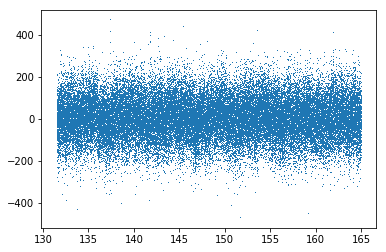

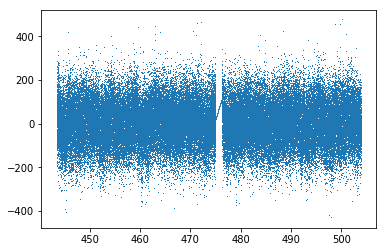

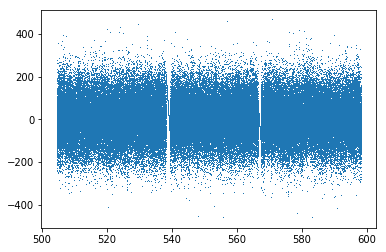

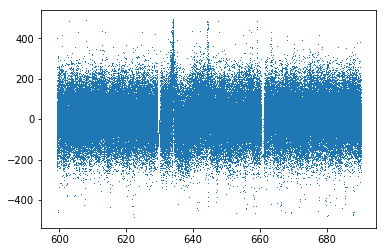

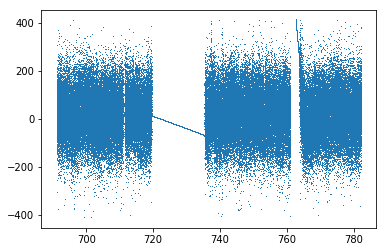

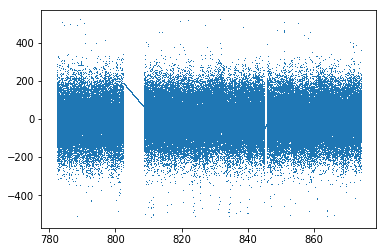

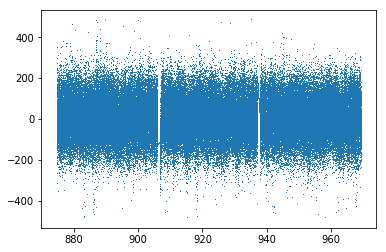

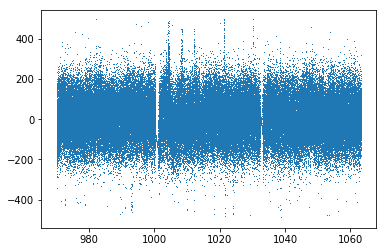

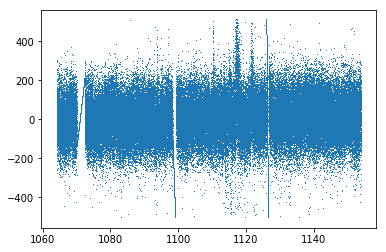

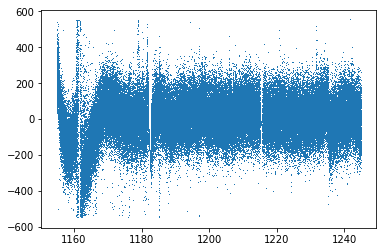

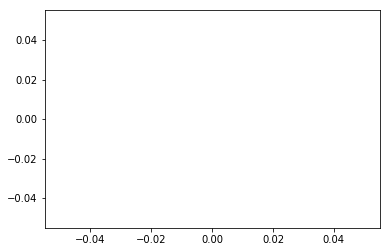

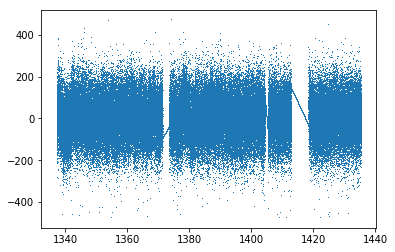

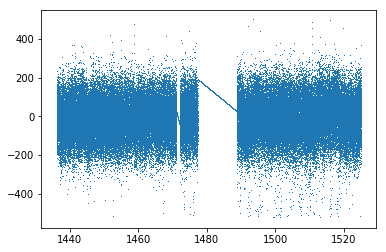

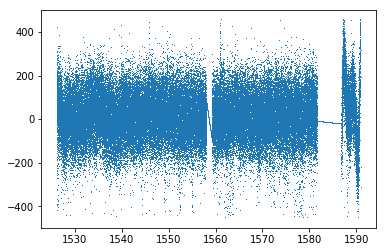

In [6]:
gap_inds = np.concatenate([[0], np.ix_(gaps)[0], [len(time)]])

chunks = []
for i in range(len(gap_inds) - 1):
    t, f = time[gap_inds[i]+1:gap_inds[i+1]], flux[gap_inds[i]+1:gap_inds[i+1]]
    t, f = interpolate_missing_data(t, f)
    f = sigma_clipping.sigma_clip(f, sigma=5, stdfunc=mad_std)
    
    if t.ptp() > 5: 
        #t, f = interpolate_missing_data(t, f)
        chunks.append([t, (f-np.nanmedian(f))])
        plt.plot(t, 1e6*(f-np.nanmedian(f)), ',')
        plt.show()

In [7]:
times = np.concatenate([chunk[0][~chunk[1].mask] for chunk in chunks])
fluxes = np.concatenate([chunk[1][~chunk[1].mask] for chunk in chunks])

times, fluxes = interpolate_missing_data(times[np.argsort(times)], fluxes[np.argsort(times)])

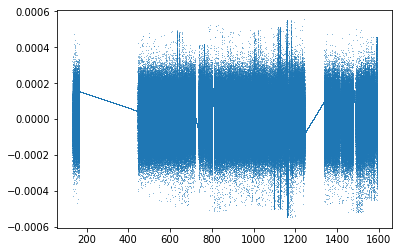

In [8]:
plt.plot(times, fluxes, ',', alpha=0.5)

In [9]:
from scipy.signal import periodogram

# freqs = []
# powers = []
# for chunk in chunks: 
#     print(chunk[1].mean())
#     freq, power = periodogram(chunk[1], fs=1/60, )
#     freqs.append(freq)
#     powers.append(power)
# freqs = np.concatenate(freqs) * 1e6
# powers = np.concatenate(powers)

freqs, powers = periodogram(fluxes, fs=1/60)
freqs *= 1e6

In [10]:
from scipy.stats import binned_statistic

cutoff_freq = 1e5
bs = binned_statistic(np.log(freqs[freqs != 0]), powers[freqs != 0], statistic=np.nanmedian, bins=10000)
bincenters = 0.5 * (bs.bin_edges[:-1] + bs.bin_edges[1:])
binned_power = bs.statistic[np.exp(bincenters) < cutoff_freq]
binned_freq = np.exp(bincenters)[np.exp(bincenters) < cutoff_freq]

/Users/bmmorris/anaconda/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


(1e-08, 1e-05)

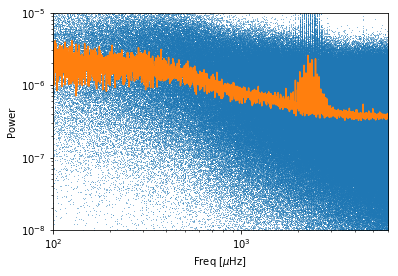

In [11]:
plt.loglog(freqs, powers, ',', alpha=0.5)
plt.loglog(binned_freq, binned_power)
plt.xlabel('Freq [$\mu$Hz]')
plt.ylabel('Power')
plt.xlim([1e2, 6e3])
plt.ylim([1e-8, 1e-5])

(1e-08, 1e-05)

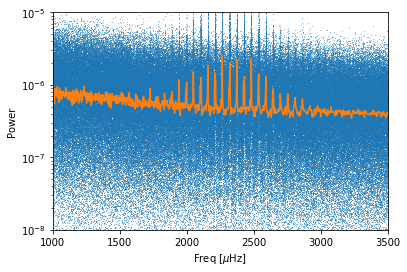

In [12]:
from scipy.ndimage import gaussian_filter1d

plt.semilogy(freqs, powers, ',', alpha=0.5)
# plt.semilogy(freqs[np.argsort(freqs)], gaussian_filter1d(powers[np.argsort(freqs)], 100))
plt.semilogy(binned_freq, binned_power)

plt.xlabel('Freq [$\mu$Hz]')
plt.ylabel('Power')
plt.xlim([1000, 3500])
plt.ylim([1e-8, 1e-5])

In [13]:
import sys
sys.path.insert(0, '../')

from shocksgo import generate_stellar_fluxes

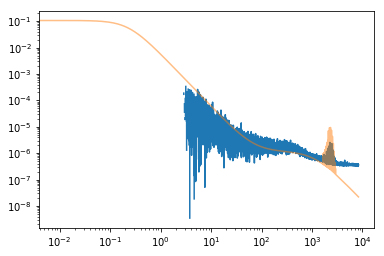

In [14]:
from astropy.constants import M_sun, L_sun
import astropy.units as u

M = 1.027 * M_sun #  KIC
T_eff = 5605.33	 * u.K # Gaia DR2
L = 1.231 * L_sun # Gaia DR2
fluxes, kernel = generate_stellar_fluxes(size=1e5, M=M, T_eff=T_eff, L=L)

plt.semilogy(binned_freq, binned_power)

plt.loglog(freqs, kernel.get_psd(2*np.pi*freqs*1e-6), alpha=0.5)

(1e-08, 0.0001)

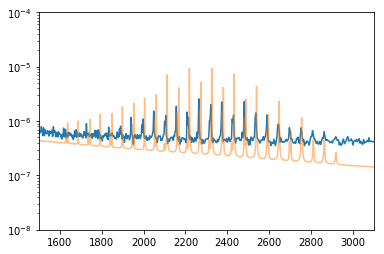

In [15]:
plt.semilogy(binned_freq, binned_power)

plt.semilogy(freqs, kernel.get_psd(2*np.pi*freqs*1e-6), alpha=0.5)
plt.xlim([1500, 3100])
plt.ylim([1e-8, 1e-4])